### Races with equal number 

In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN
df_cleaned = df.dropna(subset=['Patient Race'])

In [4]:
# Group by 'Subject ID' to handle multiple images per patient
grouped = df_cleaned.groupby('Subject ID')

# Randomly select one image per patient
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Label mapping for converting race categories to integers
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Convert the 'Patient Race' to integer labels
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

In [5]:
num_patients = df_single_image_per_patient['Subject ID'].nunique()
num_images = len(df_single_image_per_patient)

# Print the results
print(f"Number of unique patients: {num_patients}")
print(f"Number of images after selecting one per patient: {num_images}")

Number of unique patients: 25826
Number of images after selecting one per patient: 25826


Class distribution after cleaning:
White                                        23969
Black or African-American                     1135
Asian                                          547
American Indian or Alaskan Native               88
Native Hawaiian or Other Pacific Islander       87
Name: Patient Race, dtype: int64


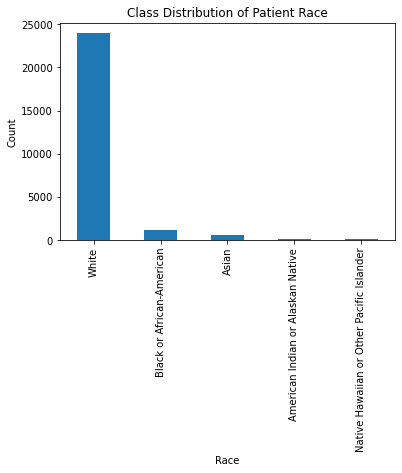

In [6]:
import matplotlib.pyplot as plt
# Check class distribution
print("Class distribution after cleaning:")
print(df_single_image_per_patient['Patient Race'].value_counts())

# Plot class distribution
df_single_image_per_patient['Patient Race'].value_counts().plot(kind='bar', title="Class Distribution of Patient Race", xlabel="Race", ylabel="Count")
plt.show()

In [7]:
# Separate the classes
df_majority = df_single_image_per_patient[df_single_image_per_patient['Patient Race'] == "White"]
df_minority = df_single_image_per_patient[df_single_image_per_patient['Patient Race'] != "White"]

# Downsample the majority class to the size of the largest minority class (e.g., "Black or African-American")
num_samples_minority = df_minority['Patient Race'].value_counts().max()
df_majority_downsampled = df_majority.sample(num_samples_minority, random_state=42)

# Combine the downsampled majority class with all minority classes
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Check the new class distribution
print("Balanced Class Distribution:")
print(df_balanced['Patient Race'].value_counts())

Balanced Class Distribution:
White                                        1135
Black or African-American                    1135
Asian                                         547
American Indian or Alaskan Native              88
Native Hawaiian or Other Pacific Islander      87
Name: Patient Race, dtype: int64


In [8]:
print("Shape of the cleaned DataFrame:", df_balanced.shape)

Shape of the cleaned DataFrame: (2992, 21)


In [9]:
# Split the data into training and validation sets (stratified by race)
X_train, X_val, y_train, y_val = train_test_split(
    df_balanced['File Location'],  # File paths to the DICOM images
    df_balanced['Race_Label'],     # Race labels as integers
    test_size=0.2, 
    stratify=df_balanced['Patient Race'], 
    random_state=42
)

In [10]:
current_path = os.getcwd()
print(current_path)

u:\GitHub\AI-ethnicity-med-image


In [11]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [12]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((224, 224))  # Resize to 224x224 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [13]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

# Now, check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

# Print the correct number of images and labels
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of training images: 2393
Number of validation images: 599
Number of training labels: 2393
Number of validation labels: 599


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [15]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
num_classes = 5
output = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

In [16]:
# Define class weights inversely proportional to class frequency
class_weights = {
    0: 1.0,  # White
    1: 10.0, # Black or African-American
    2: 5.0,  # Asian
    3: 15.0, # American Indian or Alaskan Native
    4: 15.0  # Native Hawaiian or Other Pacific Islander
}

In [18]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=10, 
                    batch_size=32,
                    class_weight=class_weights)

# Save the model
model.save('ethnicity_classification_model.h5')

Epoch 1/10
75/75 [==============================] - 126s 2s/step - loss: 59.6049 - accuracy: 0.3932 - val_loss: 1.6943 - val_accuracy: 0.4073
Epoch 2/10
75/75 [==============================] - 170s 2s/step - loss: 7.7200 - accuracy: 0.4509 - val_loss: 1.3635 - val_accuracy: 0.4841
Epoch 3/10
75/75 [==============================] - 121s 2s/step - loss: 7.2159 - accuracy: 0.4760 - val_loss: 1.3640 - val_accuracy: 0.4841
Epoch 4/10
75/75 [==============================] - 121s 2s/step - loss: 7.1191 - accuracy: 0.4764 - val_loss: 1.3761 - val_accuracy: 0.4841
Epoch 5/10
75/75 [==============================] - 119s 2s/step - loss: 6.9652 - accuracy: 0.4664 - val_loss: 1.4221 - val_accuracy: 0.4841
Epoch 6/10
75/75 [==============================] - 121s 2s/step - loss: 6.9312 - accuracy: 0.4634 - val_loss: 1.3177 - val_accuracy: 0.4841
Epoch 7/10
75/75 [==============================] - 116s 2s/step - loss: 6.8449 - accuracy: 0.4446 - val_loss: 1.4021 - val_accuracy: 0.4841
Epoch 8/10
7

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Fine-tune the Existing Model

In [16]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:200]:  # Freeze only the first 200 layers
    layer.trainable = False
    
# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
num_classes = 5
output = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Re-compile the model before re-training
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using the generator
history = model.fit(X_train_images, 
                    y_train_labels, 
                    validation_data=(X_val_images, y_val_labels), 
                    epochs=10, 
                    batch_size=32)

# Save the model
model.save('ethnicity_classification_model.h5')

Epoch 1/10
75/75 [==============================] - 169s 2s/step - loss: 1.4249 - accuracy: 0.4459 - val_loss: 1.2520 - val_accuracy: 0.4240
Epoch 2/10
75/75 [==============================] - 161s 2s/step - loss: 1.1706 - accuracy: 0.4810 - val_loss: 1.1492 - val_accuracy: 0.4791
Epoch 3/10
75/75 [==============================] - 164s 2s/step - loss: 1.1342 - accuracy: 0.4885 - val_loss: 1.0476 - val_accuracy: 0.4791
Epoch 4/10
75/75 [==============================] - 165s 2s/step - loss: 1.1082 - accuracy: 0.4881 - val_loss: 1.0470 - val_accuracy: 0.4775
Epoch 5/10
75/75 [==============================] - 153s 2s/step - loss: 1.0879 - accuracy: 0.4764 - val_loss: 1.0417 - val_accuracy: 0.4791
Epoch 6/10
75/75 [==============================] - 157s 2s/step - loss: 1.0854 - accuracy: 0.4985 - val_loss: 1.0330 - val_accuracy: 0.4808
Epoch 7/10
75/75 [==============================] - 166s 2s/step - loss: 1.0782 - accuracy: 0.5027 - val_loss: 1.0315 - val_accuracy: 0.4891
Epoch 8/10
75

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Result

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

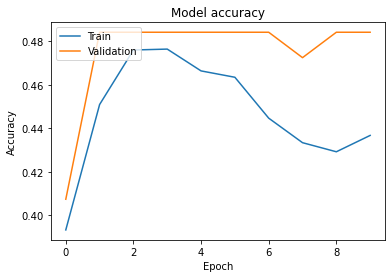

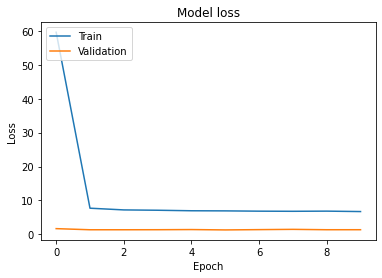

In [20]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [21]:
# Make predictions on the validation set
y_pred = model.predict(X_val_images)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

Accuracy: 0.4841


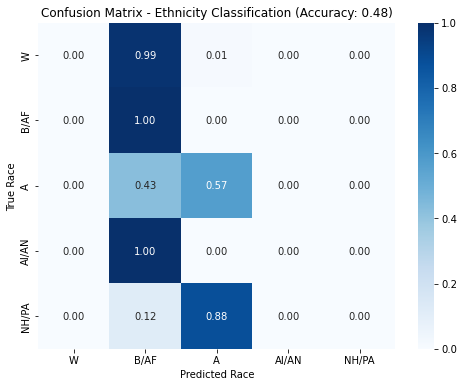

In [23]:
# Create a confusion matrix
cm = confusion_matrix(y_val_labels, y_pred_labels)

cma = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define race labels
race_labels = ['W', 'B/AF', 'A', 'AI/AN', 'NH/PA']

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cma, annot=True, fmt='.2f', cmap='Blues', xticklabels=race_labels, yticklabels=race_labels)
plt.xlabel('Predicted Race')
plt.ylabel('True Race')
plt.title(f'Confusion Matrix - Ethnicity Classification (Accuracy: {accuracy:.2f})')
plt.show()

In [24]:
# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_val_labels, y_pred_labels, target_names=label_mapping.keys(), zero_division=1))

Classification Report:
                                           precision    recall  f1-score   support

                                    White       1.00      0.00      0.00       227
                Black or African-American       0.44      1.00      0.61       227
                                    Asian       0.78      0.57      0.66       110
        American Indian or Alaskan Native       1.00      0.00      0.00        18
Native Hawaiian or Other Pacific Islander       1.00      0.00      0.00        17

                                 accuracy                           0.48       599
                                macro avg       0.84      0.31      0.25       599
                             weighted avg       0.75      0.48      0.35       599

